# HOMEWORK 2(exercise 1)

## This file contains solution for 1st exercise (note: Please see the other file for exercise 2 and bonus solutions)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
from bs4 import BeautifulSoup as BSoup
import requests
import pandas as pd
import seaborn as sns
import scipy.stats as stats
sns.set_context('notebook')

## Main assumption
#### In the first exercise, we assume that it takes at least 6 semesters to graduate from bachelor degree. So, when the number of semesters are less than 6, we drop that information since we consider those students as failed to graduate(or haven't graduated yet,so we can't assume how much time it will take for them to graduate).

### Following part is link data(HTTP request variables) extraction for URLs that will be used for HTTP requests

In [2]:
# The following code stores the values by parsing the html file which are going to 
#be used in request.get for data getting
r = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247&ww_c_langue=&ww_i_reportModelXsl=133685270')
soup = BSoup(r.text.encode('utf-8'),'lxml')
links = soup.find_all("select")

value_years = {} # Initilizing the datas
years = []
value_semesters = {}
semester = []

for i in range(2007,2017):
    value_years[str(i)] = []
    years.append(str(i))
for i in range(1,7):
    value_semesters['Bachelor semestre '+str(i)] = []
    semester.append('Bachelor semestre '+str(i))
value_semesters['Bachelor semestre '+str(5)+'b'] = []
value_semesters['Bachelor semestre '+str(6)+'b'] = []
semester.append('Bachelor semestre '+str(5)+'b')
semester.append('Bachelor semestre '+str(6)+'b')

for link in links:                     
    namesAll = link.find_all("option")
    for names in namesAll:
        #print(names.contents)
        if names.contents:
            if names.contents[0][:4] in years: # stores the values for years
                value_years[str(names.contents[0][:4])] = names['value']
            elif names.contents[0] == 'Informatique': # stores the value for field Informatique
                value_informatiq = int(names['value'])
            elif names.contents[0] in semester: # stores the values for semesters
                value_semesters[names.contents[0]] = names['value']

#### This function is used to get the table from the query

In [3]:
def get_data3(query):
    r = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.bhtml?ww_x_GPS=-1&ww_i_reportmodel=133685247&ww_i_reportModelXsl=133685270',params=query)
    soup = BSoup(r.text.encode('utf-8'),'lxml')
    table_soup = soup.find('table')
    #data inside the cells of table
    data_cell = table_soup.find_all('td')#.renderContents()#.strip()
    d=[]
    st = []
    h = []
    for entry in data_cell:
        s = entry.text
        s = s.replace(u'\xa0', u' ')
        s = s.replace(u'Ã©',u'e') 
        d.append(s)
    #headers
    headers=soup.findAll('th')
    for header in headers[1:]:
        temp = header.text
        temp = temp.replace(u'Ã©',u'e')
        h.append(temp)
        
    #for getting current semester info
    headers=soup.findAll('th')
    #creating dataframe with the obtained data
    st=[d[x:x+11] for x in range(0,len(d),12)]
    dfr=pd.DataFrame(st,columns=h[:11])
    return dfr

#### After getting the link data we do requests and gather the information

In [4]:
#Dataframe 'result' will keep track of all dataframes combined

result=pd.DataFrame() #empty dataframe
count=0 # will be used to get the header from the first link


for y in range(2007,2017): # concatenating whole data into a pandas dataframe
    for vS in semester:
        query = {'ww_x_UNITE_ACAD' : value_informatiq,'ww_x_PERIODE_ACAD':value_years[str(y)],
        'ww_x_PERIODE_PEDAGO':value_semesters[vS]}
        data = get_data3(query)
        result=pd.concat([result,data])#,ignore_index=True)       

#### Now 'result' contains all the data of all bachelor students that began their bachelor in 2007. 
#### We change the index of dataframe to be 'No Sciper' since each student can be determined by it 

In [5]:
result_s=result.set_index('No Sciper')
resultx=result['No Sciper']#indices
counter=0 # counts number of students that have less than 6 semesters at EPFL(either because still studies or stopped)
# Remove students with less than 6 semesters
for i in resultx:
    if ((result_s.index==i).sum()<6):
        #counter=counter+1
        result_s=result_s.drop([i])#,axis=0)
# For the remaining students(result_s) compute how many months it took for them to complete studies:
#result_s.reset_index(level=0, inplace=True)
#result_s=result_s.drop_duplicates(subset='index', keep='last')
n_index=result_s.index
#female and male student SCIPER numbers
female=result_s[result_s['Civilite']=='Madame'].index 
male=result_s[result_s['Civilite']=='Monsieur'].index

### Assumption: We calculated the time it took for the student to graduate as the number of semesters she/he registered at is-academia.
#### 'duration' lists keep number of semesters student spends in university

In [6]:
#general
duration=[]
for ind in n_index:
    t=(result_s.index==ind).sum()
    t=6*t
    duration.append(t)
#female    
duration_f=[]
for ind in female:
    t=(result_s.index==ind).sum()
    t=6*t
    duration_f.append(t)
#male
duration_m=[]
for ind in male:
    t=(result_s.index==ind).sum()
    t=6*t
    duration_m.append(t)

#### Below we make data more organized to only make the dataframe consisting of student id and corresponding number of months it took to study at epfl.

In [7]:
information=pd.DataFrame(duration, index=n_index)
information.reset_index(level=0, inplace=True)
infor=information.drop_duplicates(subset='No Sciper',keep='last')
infor=infor.set_index('No Sciper')
infor.columns=['months']

#same operations for female and male students
information_f=pd.DataFrame(duration_f,index=female)
information_f.reset_index(level=0, inplace=True)
infor_f=information_f.drop_duplicates(subset='No Sciper',keep='last')
infor_f=infor_f.set_index('No Sciper')
infor_f.columns=['months']

information_m=pd.DataFrame(duration_m,index=male)
information_m.reset_index(level=0, inplace=True)
infor_m=information_m.drop_duplicates(subset='No Sciper',keep='last')
infor_m=infor_m.set_index('No Sciper')
infor_m.columns=['months']

#### Now let's analyze data

##################
DATA SUMMARY FOR ALL(bachelor) STUDENTS
##################


Average duration is 41.9872340426, median for all students is 36.0, std is 8.54386940951
Overall among all students 55.3191489362 percent graduated on expected time which is 36 months


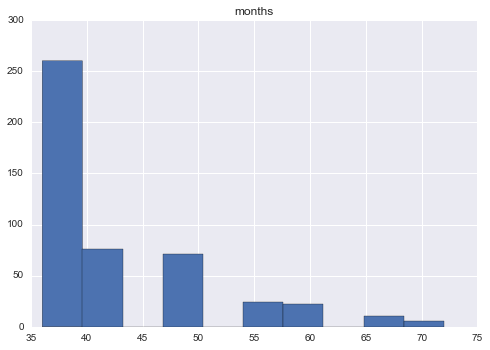

In [8]:
#general analysis
infor.hist()
print('##################')
print('DATA SUMMARY FOR ALL(bachelor) STUDENTS')
print('##################')
print('\n')
mediang=infor.median()
meang=infor.mean()  #average number of semesters
stdg=infor.std()
print('Average duration is '+ str(meang.values[0]) + ', median for all students is ' + str(mediang.values[0]) + ', std is ' + str(stdg.values[0]) )
on_time_students=(infor==6*6).sum()/len(infor)*100 #portion of students that graduated in 6 semesters(in percent)
print('Overall among all students ' + str(on_time_students.values[0]) + ' percent graduated on expected time which is 36 months')

##################
DATA SUMMARY FOR MALE STUDENTS
##################


Average duration is 42.0821917808, median for male students is 36.0, std is 8.60060147648
Overall among all male students 54.5662100457 percent graduated on expected time which is 36 months


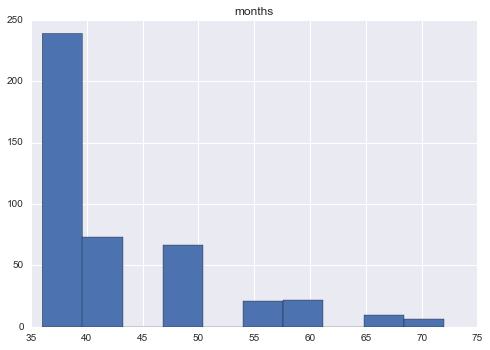

In [9]:
#male
infor_m.hist()
print('##################')
print('DATA SUMMARY FOR MALE STUDENTS')
print('##################')
print('\n')
medianm=infor_m.median()
meanm=infor_m.mean()  #average number of semesters
stdm=infor_m.std()
print('Average duration is '+ str(meanm.values[0]) + ', median for male students is ' + str(medianm.values[0]) + ', std is ' + str(stdm.values[0]) )
on_time_boys=(infor_m==6*6).sum()/len(infor_m)*100 #portion of boys that graduated in 6 semesters(in percent)
print('Overall among all male students ' + str(on_time_boys.values[0]) + ' percent graduated on expected time which is 36 months')

##################
DATA SUMMARY FOR FEMALE STUDENTS
##################


Average duration is 40.6875, median for female students is 36.0, std is 7.73111643234
Overall among all students 65.625 percent graduated on expected time which is 36 months


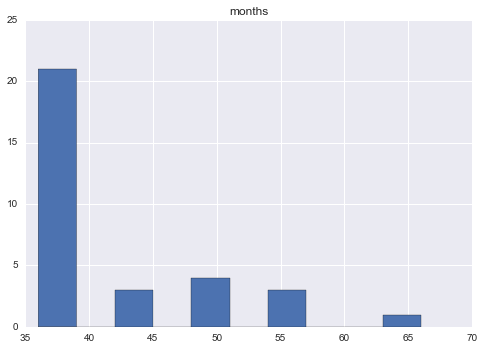

In [10]:
#female
infor_f.hist()
print('##################')
print('DATA SUMMARY FOR FEMALE STUDENTS')
print('##################')
print('\n')
medianf=infor_f.median()
meanf=infor_f.mean()  #average number of semesters
stdf=infor_f.std()
print('Average duration is '+ str(meanf.values[0]) + ', median for female students is ' + str(medianf.values[0]) + ', std is ' + str(stdf.values[0]) )
on_time_girls=(infor_f==6*6).sum()/len(infor_f)*100 #portion of girls that graduated in 6 semesters(in percent)
print('Overall among all students ' + str(on_time_girls.values[0]) + ' percent graduated on expected time which is 36 months')

## The two means are not significantly different.
** We use the Two-Sample T-Test, as we want to check whether two distribution (namely duration of study of males and females) differ or not based on the two samples of distributions.
 Considering the Null Hypothesis to be that the two distributions are same, we implement the T-Test and as it is seen with 33% probability we'd see the obtained result if the two groups are actually identical, hence we can not reject the null hypothesis (we considered 95% confidence level, which is far from the obtained result).**

In [11]:
stats.ttest_ind(a=infor_f,b=infor_m,equal_var=False)

Ttest_indResult(statistic=array([-0.97727042]), pvalue=array([ 0.33480979]))